# Good Vibes: The Probability of Earthquake Magnitude and Death
*The Final Report for the Introduction to Data Science Project*  
  
**Team Fugacity Members**  
Paul Mundt, u0932146  
Katie Jones, u0541901  

## Introduction [Check Off: Katie, Paul]

### Motivations [Edits Needed]
  
Last year on February 15th, 2019 at 05:09am (MST) a 3.7M earthquake hit Bluffdale, UT. The magnitude was enough for residents in neighboring cities such as Draper and Riverton, to feel the ground shake. This caused many people in the area to wonder about their safety as well as their preparedness for if another earthquake were to occur. As residents of a city built on a faultline, we are keenly aware of the ubiquity of earthquakes as a disruption life in Salt Lake City.  
  
Earthquakes happen all over the world, most of which we cannot feel. As citizens living along a major faultline, the question of earthquake magnitude and danger is always a concern. This project will look at the historical data of earthquakes around the globe and determine the danger of displacement, property damage, injury, and death (called impact factors from this point forward) in relation to earthquake magnitude and other socioeconomic factors.
  
  
### Project Objectives [Edits Needed]
  
For this project, we are trying to answer the following questions about earthquakes and their impacts:

**1**) Can impact factors be predicted based on magnitude of the earthquake?
  
**2**) What is the probability of displacement, property damage, injury, or death in an earthquake?
  
**3**) How do socioeconomic factors, like GDP of the country, population density, etc, affects the accuracy of impact factor predictions?
  
**4**) Does clustering of data prior to analysis increase the accuracy of the predictive models? 
  
We will be investigating these claims by analyzing seismographic information about earthquakes, information about effects of earthquakes, and looking at a variety of other data types (national GDP, population, population density, etc) . 
 
Additionally, we hope to apply the data collected to a geomap for a visualization of earthquake locations and severity. 
  
### Ethical Considerations [Edits Needed]
  
The main stakeholders in a data science project like this are general civilians and people involved in infrastructure (architects, city planners, civil engineers, law makers, etc). 
To the general citizen, this project can be both incredibly informative as well as fear inducing. Most people only gain exposure to earthquakes after a major disaster. Because of this, many people inherently fear earthquakes and the impact that they have on daily life. For this project, it is important that all correlations and statistics we explore are accurately and accessible explained and given context. As is often the case, the context given to the data is usually more important than what the data itself says. 
  
This project will also be useful for people involved in infrastructure. By showing what variables that affect impact factors, the people incharge of building structures in a city might be better informed on the need for earthquake resistant structures. Areas of frequent high magnitude earthquakes are supposedly safer than those with the semi-active seismic activity. We believe this is because infrastructure and response are more highly valued when building in the area, as more frequent danger incentivises buildings to be designed to withstand move intense oscillation.

## Data Collection and Cleaning [Check Off: Katie, Paul]

### Earthquakes and Impact Factor Data [Edits Needed]
The primary source of data was the Earthquake Impact Database from earthquake-report.com. The database from the website is linked to a set of Goolge sheets that can be saved as a CSV. The CSV files had to be copied and saved to replace formulas with text. This was done using Excel's specialty paste functionality.  
The data was collected from January 1,2017 to March 17th, 2020. 

In [1]:
# Import all packages and functions needed for entire analysis
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import scipy as sci
from requests import get
import folium
from geopy.geocoders import ArcGIS
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pycountry
import re
from scipy.cluster import hierarchy 
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (12, 12) 
import statsmodels.formula.api as sm

In [2]:
# Import CSV Files Extracted from the Earthquake Impact Database
data_2017 = pd.read_csv("2017_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2018 = pd.read_csv("2018_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

In [3]:
# Clean 2017 Data
data_2017 = data_2017.drop('Depth (km)', axis = 1).drop('Tsunami height', axis = 1)
data_2017 = data_2017.fillna(value = 0).replace("--", "0")
latlong_2017 = [0 for _ in range(0, len(data_2017.index))]
data_2017.insert(loc = 4, column = 'Lat', value = latlong_2017)
data_2017.insert(loc = 5, column = 'Long', value = latlong_2017)
data_2017 = data_2017.rename(columns = {"Impact coefficient (D)" : "Impact value (D)"} )

# Clean 2018 Data
data_2018 = data_2018.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2018 = data_2018.fillna(value = 0).replace("--", "0")
latlong_2018 = [0 for _ in range(0, len(data_2018.index))]
data_2018.insert(loc = 4, column = 'Lat', value = latlong_2018)
data_2018.insert(loc = 5, column = 'Long', value = latlong_2018)
data_2018 = data_2018.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

# Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

# Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

In [4]:
# Concatenate Dataframes into a Single Dataset
earthquake_data = pd.concat([data_2017, data_2018, data_2019, data_2020], sort = False).reset_index(drop = True)
Database = pd.concat([data_2019, data_2020], sort = False).reset_index(drop = True)

In [5]:
# Convert "Intensity (MMI / JMA)" Column from Roman Numerals to Integers
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('+',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('-',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('JMA',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('Shindo ','')

Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('+',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('-',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('JMA',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('Shindo ','')

def roman_to_number(num):
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L':50 , 'C':100, 'D':500, 'M':1000}
    res=0
    i=0
    while i<len(num):
        s1=num[i]
        num1=rom_val[s1]
        if i+1<len(num):
            s2=num[i+1]
            num2=rom_val[s2]
            if num2<=num1:
                res=res+num1
                i+=1
            else:
                res=res+num2-num1
                i+=2
        else:
            res=res+num1
            i+=1
    return(res)
        
    
           
def change(num):
    if type(num)==str:
        if len(num)>4:
            tip=num[0:len(num)//2].strip()
        else:
            tip=num.strip()
        try:
            return(int(tip))
        except:
            return(roman_to_number(tip))
    else:
        return(num)
earthquake_data['Intensity (MMI / JMA)']=[change(chest) for chest in earthquake_data['Intensity (MMI / JMA)']]
Database['Intensity (MMI / JMA)']=[change(chest) for chest in Database['Intensity (MMI / JMA)']]

In [6]:
# Print Cleaned DataFrame
earthquake_data

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed
0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,5.0,0.0,0.0,30.0,0.194401,0.0,0.0
1,1/3/2017,India,Tripura,5.5,0.00,0.00,NaN,3.0,49.0,600.0,1.668774,1456.0,166.0
2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,NaN,0.0,0.0,0.0,0.752967,500.0,0.0
3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,4.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1/6/2017,Iran,Fars,5.1,0.00,0.00,NaN,4.0,4.0,905.0,1.447852,400.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,3/13/2020,India,Kerala,2.8,9.79,76.88,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
934,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,NaN,0.0,0.0,0.0,0.007925,2.0,0.0
935,3/14/2020,Iran,Qom,4.0,34.56,50.72,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
936,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,NaN,0.0,2.0,0.0,0.235972,20.0,1.0


### Socioeconomic Information
Socioeconomic information based on country was scraped from World-o-meters.info.

In [7]:
#Scrape Socioeconomic Information
url = 'https://www.worldometers.info/gdp/gdp-by-country/'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')
Head=soup.find('thead')
H=Head.find_all('th')
Table=soup.find('tbody')
T=Table.find_all('tr')
columns=[col for col in T[0]]
Beep=[T[i] for i in range(0,len(T))]
headers=[i.get_text() for i in H]

tipping=[]
for col in columns:
    if col==' ':
        pass
    else:
        tipping.append(col.get_text())
tip=[]
for i in range(0,len(T)):
    clip=[]
    columns=[col for col in T[i]]
    for col in columns:
        if col==' ':
            pass
        else:
            clip.append(col.get_text())
    tip.append(clip)
gdp=pd.DataFrame(tip,columns=headers)

#cleaning GDP nominal
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace('$',' ')
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace(',','').astype(float)
gdp['GDP (nominal, 2017) ']=pd.to_numeric(gdp['GDP (nominal, 2017) '] )
gdp.rename(columns={'GDP (nominal, 2017) ':'GDP($)'}, inplace=True)

#Cleanng GDP abbrev
gdp['GDP (abbrev.)']=gdp['GDP (abbrev.)'].str.replace('$',' ')
def money(num,part):
    if part=='trillion':
        num=num*1000000000000
    elif part=='billion':
        num=num*1000000000
    else:
        num=num*1000000
    return(num)

def marker(plop):
    mak=len(plop)//2
    num=plop[0:mak]
    word=plop[mak:len(plop)]
    if word=='illion' or word=='rillion' :
        num=float(plop[0:mak-1])
        word=plop[mak-1:len(plop)]
        return(money(num,word))
    else:
        return(money(float(num),word))
gdp['GDP (abbrev.)']=[marker(i) for i in gdp['GDP (abbrev.)']]
gdp.rename(columns={'GDP (abbrev.)':'GDP (abbrev.)($)'}, inplace=True)

#clean growth
gdp['GDP  growth']=gdp['GDP  growth'].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'GDP  growth':'GDP  growth(%)'}, inplace=True)
#clean population
gdp['Population (2017) ']=gdp['Population (2017) '].str.replace(',','').astype(int)
gdp.rename(columns={'Population (2017) ':'Population'}, inplace=True)
#clean per capita
gdp['GDP  per capita ']=gdp['GDP  per capita '].str.replace('$',' ').str.replace(',','').astype(int)
gdp.rename(columns={'GDP  per capita ':'GDP  per capita ($)'}, inplace=True)
#share of GDP
gdp['Share of World GDP ']=gdp['Share of World GDP '].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'Share of World GDP ':'Share of World GDP (%)'}, inplace=True)

In [8]:
# print DataFrame
gdp

,#,Country,GDP($),GDP (abbrev.)($),GDP growth(%),Population,GDP per capita ($),Share of World GDP (%)
0,1,United States,1.948539e+13,1.948500e+13,0.0227,325084756,59939,0.2408
1,2,China,1.223770e+13,1.223800e+13,0.0690,1421021791,8612,0.1512
2,3,Japan,4.872415e+12,4.872000e+12,0.0171,127502725,38214,0.0602
3,4,Germany,3.693204e+12,3.693000e+12,0.0222,82658409,44680,0.0456
4,5,India,2.650725e+12,2.651000e+12,0.0668,1338676785,1980,0.0328
...,...,...,...,...,...,...,...,...
184,185,Sao Tome & Principe,3.925703e+08,3.930000e+08,0.0387,207089,1896,0.0000
185,186,Palau,2.898235e+08,2.900000e+08,-0.0357,17808,16275,0.0000
186,187,Marshall Islands,2.041734e+08,2.040000e+08,0.0360,58058,3517,0.0000
187,188,Kiribati,1.855725e+08,1.860000e+08,0.0033,114158,1626,0.0000


### Adding Socioeconomic Data to Earthquake Data
Next we used the "GDP" DataFrame as a database of sorts. The earthquake data has the country of epicenter listed, so that was compared to the list from World-o-meter.info and the GDP, GDP per capita, and Population were added to the earthquake data.  
In the World-o-meter.info data, information about 4 countries were missing: Taiwan, Venezuela, Myamnar, and Cayman Islands. The pertinent information about these countries was collected from their Wikipedia pages and added manually to earthquakes located in those countires. 

In [9]:
#Add GDP, Population and GDP per captia to lists for addition to DF

gdp_column = []
pop_column = []
gdp_per_cap_column = []

for i in range(len(earthquake_data)):
    country = earthquake_data.iloc[i, 1]
    if country == "Taiwan":
        gdp_column.append(586104000000)
        pop_column.append(23780452)
        gdp_per_cap_column.append(24828)
    if country == "Venezuela":
        gdp_column.append(70140000000)
        pop_column.append(28887118)
        gdp_per_cap_column.append(2548)
    if country == "Myamnar":
        gdp_column.append(355000000000)
        pop_column.append(53582855)
        gdp_per_cap_column.append(6707)
    if country == "Cayman Islands":
        gdp_column.append(4571000000)
        pop_column.append(68076)
        gdp_per_cap_column.append(70958)
    for j in range(len(gdp)):
        if gdp.iloc[j, 1] == country:
            gdp_column.append(gdp.iloc[j, 2])
            pop_column.append(gdp.iloc[j, 5])
            gdp_per_cap_column.append(gdp.iloc[j, 6])
            break

# Insert columns onto dataframe
earthquake_data.insert(loc = 13, column = 'GDP', value = gdp_column)
earthquake_data.insert(loc = 14, column = 'Population', value = pop_column)
earthquake_data.insert(loc = 15, column = 'GDPPerCapita', value = gdp_per_cap_column)

### Finding Countries related to continents and land area

In [10]:
url1 = 'https://www.worldatlas.com/cntycont.htm'
url2='https://www.nationmaster.com/country-info/stats/Geography/Land-area/Square-miles'

response=get(url1)
soup=BeautifulSoup(response.text,'html.parser')

Tropicanna=soup.find('div',class_="miscTxt")
continents=Tropicanna.find_all('h2')
cont_counts=Tropicanna.find_all('ul')
top=cont_counts[1].find_all('li')
Conts=[con.get_text() for con in continents]
Countries=[]
Continets=[]
for j in range(len(Conts)-2):
    stuff=Conts[j]
    top=cont_counts[j].find_all('li')
    for steel in top:
        Countries.append(steel.get_text())
        Continets.append(stuff)

ConCun=pd.DataFrame(zip(Countries,Continets), columns=['Country','Continents'])
ConCun['Continents']=ConCun['Continents'].str.replace('(','').str.replace(')','').str.replace('\n','')
ConCun['Continents']=[title[0:len(title)-3] for title in ConCun['Continents']]

response1=get(url2)
sauce=BeautifulSoup(response1.text,'html.parser')

tim=sauce.find('tbody')
info=tim.find_all('tr')
country=[]
land=[]
for i in range(0,len(info)):
    test=info[i].find_all('td')
    country.append(test[1].get_text())
    land.append(test[2].get_text().strip())
    
landmass=pd.DataFrame(zip(country,land), columns=['Country','Landarea'])
landmass['Country']=landmass['Country'].str.replace('\n','')
Information=ConCun.join(landmass.set_index('Country'), on='Country')

Information['Landarea']=Information['Landarea'].str.replace('square miles','').str.replace(',','')
time=[]
#for x in Information['Landarea']:
#    if 'million' in x:
#        time.append(float(x[0:4])*1000000)
#    else:
#        time.append(float(x))

        
#Information['Landarea']=time
earthquake_data=earthquake_data.join(Information.set_index('Country'), on='Country')

In [11]:
# print final DataFrame
earthquake_data

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed,GDP,Population,GDPPerCapita,Continents,Landarea
0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,5.0,0.0,0.0,30.0,0.194401,0.0,0.0,1.943835e+12,60673701,32038,EUROPE,116346
1,1/3/2017,India,Tripura,5.5,0.00,0.00,NaN,3.0,49.0,600.0,1.668774,1456.0,166.0,2.650725e+12,1338676785,1980,ASIA,1.24 million
2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,NaN,0.0,0.0,0.0,0.752967,500.0,0.0,2.053595e+12,207833823,9881,S. AMERICA,3.3 million
3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,4.0,0.0,0.0,0.0,0.000000,0.0,0.0,5.061203e+09,877459,5768,OCEANIA,7095
4,1/6/2017,Iran,Fars,5.1,0.00,0.00,NaN,4.0,4.0,905.0,1.447852,400.0,40.0,4.540128e+11,80673883,5628,ASIA,636313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,3/13/2020,India,Kerala,2.8,9.79,76.88,NaN,0.0,0.0,0.0,0.038254,10.0,0.0,2.650725e+12,1338676785,1980,ASIA,1.24 million
934,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,NaN,0.0,0.0,0.0,0.007925,2.0,0.0,5.332063e+10,54660339,975,AFRICA,364900
935,3/14/2020,Iran,Qom,4.0,34.56,50.72,NaN,0.0,0.0,0.0,0.038254,10.0,0.0,4.540128e+11,80673883,5628,ASIA,636313
936,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,NaN,0.0,2.0,0.0,0.235972,20.0,1.0,4.540128e+11,80673883,5628,ASIA,636313


## Data Exploration [Check Off: Katie, Paul]
  
The first method of data exploration was to look at a geo map of earthquake data collected from the United States Geological Society (USGS) website. This geomap was used to see if we could visually see any patterns that might inform the clustering a regression analysis we did later on. 

In [12]:
# Because of the frequency of earthquakes, USGS data takes all earthquake data all over the world and gives us the magnitude, longitude
#latitude, and depth. From there we can plot these on a Geomap or scatter plot and see if any patterns come up
url = 'http://feed.unmung.com/feed?feed=http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5+_month.atom'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')

Location=soup.find_all('a',class_="u-url")
Data=soup.find_all('span',class_="e-summary")
Location.pop(0)
def mag_title(x):
    magnitude=float(x[1:5])
    location=x[7:]
    return(magnitude,location)

Locate=[]
magni=[]
for kip in Location:
    inter=kip.get_text()
    poper=mag_title(inter)
    Locate.append(poper[1])
    magni.append(poper[0])

In [13]:
#Continueing to clean the data

time=[]
loc=[]
depth=[]
for stuff in Data:
    j=stuff.find_all('dd')
    time.append(j[0].get_text())
    loc.append(j[2].get_text())
    depth.append(j[3].get_text())   

def latitudel(x):
    if "S" in x:
        cord=-float(x.replace('°S',''))
    else:
        cord=float(x.replace('°N',''))
    return(cord)

def longitudel(x):
    if "W" in x:
        cord=-float(x.replace('°W',''))
    else:
        cord=float(x.replace('°E',''))
    return(cord)
def coord_split(x):
    half=len(x)//2
    first=x[:half]
    last=x[half:]
    return(first,last)

latitude=[]
longitude=[]
for sets in loc:
    x,y=coord_split(sets)
    latitude.append(latitudel(x))
    longitude.append(longitudel(y))

Current=pd.DataFrame(zip(time,Locate,magni,depth,latitude,longitude), columns=['time','Location','Magnitude','Depth (km)','latitude','longitude'])

def co(text):
    for country in pycountry.countries:
        if country.name in text:
            return(country.name)
t=[]
for i,text in enumerate(Current['Location']):
    j=re.findall(r",([\w\s]+)",text)
    if len(j)==0:
        if type(co(text)) is None:
            t.append(co(text))
        else:
            t.append(text)
    elif len(j)>0:
        t.extend(j)
    else:
        t.append(text)
Current['Country']=t
Current

,time,Location,Magnitude,Depth (km),latitude,longitude,Country
0,2020-04-12 13:28:30 UTC,"160km ESE of Neiafu, Tonga",4.7,10.00 km (6.21 mi),-19.194,-172.574,Tonga
1,2020-04-12 13:11:52 UTC,"73km SSW of Shizunai, Japan",4.6,54.92 km (34.13 mi),41.756,141.938,Japan
2,2020-04-12 12:47:45 UTC,"16km WSW of Rabaul, Papua New Guinea",4.8,10.00 km (6.21 mi),-4.233,152.025,Papua New Guinea
3,2020-04-12 12:31:13 UTC,"3km SSW of Riosucio, Colombia",4.8,46.00 km (28.58 mi),7.415,-77.129,Colombia
4,2020-04-12 12:25:10 UTC,"26km W of Rabaul, Papua New Guinea",5.3,10.00 km (6.21 mi),-4.223,151.937,Papua New Guinea
...,...,...,...,...,...,...,...
380,2020-03-14 10:05:15 UTC,"218km NE of Opotiki, New Zealand",5.8,48.06 km (29.86 mi),-36.545,178.816,New Zealand
381,2020-03-14 10:01:16 UTC,Kermadec Islands region,6.4,10.00 km (6.21 mi),-27.366,-175.607,Kermadec Islands region
382,2020-03-14 07:19:31 UTC,"280km NNE of Ndoi Island, Fiji",4.6,576.93 km (358.49 mi),-18.175,-178.118,Fiji
383,2020-03-14 05:15:17 UTC,"74km W of Kandrian, Papua New Guinea",4.5,60.37 km (37.51 mi),-6.170,148.881,Papua New Guinea


In [14]:
# Create and display geomap of USGS Data
def cool(m):
    if 0<=m<1:
        return('green')
    elif 1<=m<2:
        return('orange')
    elif 2<=m<3:
        return('blue')
    elif 3<=m<4:
        return('teal')
    elif 5<=m<6:
        return('purple')
    elif 6<=m<7:
        return('amber')
    else:
        return('red')
    
nom=ArcGIS()
p=nom.geocode("Palais du Gouvernement,P.O. Box 4546,N'Djaména")
map=folium.Map(location=[p.latitude,p.longitude], zoom_start=2, tiles="Stamen Terrain")

html="""<h4><b>Earquakes Info</b></h4>
<p><b>Location: </b>%s</p>
<p><b>Magnitude: </b>%s</p>"""
fgv=folium.FeatureGroup(name="shake")
for la, lo, m,l in zip(latitude,longitude,magni,Locate):
    iframe=folium.IFrame(html=html %(l,str(m)),width=200,height=100)
    fgv.add_child(folium.CircleMarker(location=[la,lo],fill_color=cool(m),popup=folium.Popup(iframe),fill=True,color='black',fill_capacity=0.9))
map.add_child(fgv)

### Scatter Matrix
Next method of data exploration is to create a cattering matrix. This allowed us to visually see coorelations between different variables of interest. 

<Figure size 1080x1080 with 0 Axes>

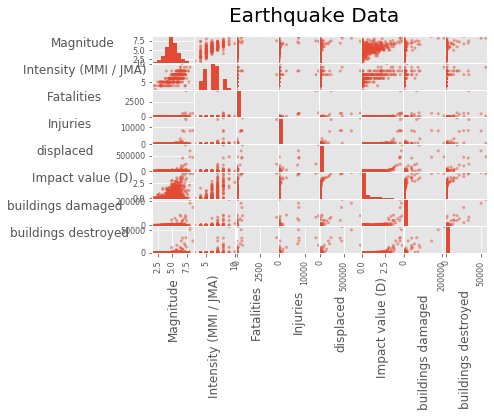

In [15]:
col=['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed']
scattering=earthquake_data[col]
plt.figure(1, figsize = (15, 15))
axs=pd.plotting.scatter_matrix(scattering)
plt.suptitle('Earthquake Data', size=20)
n = len(scattering.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

## Data Analysis [Check Off: Katie, Paul]
  
### Stage 1: Complete Data Regression
Before beginning to cluster the data and group, we are running regressions on the entire data set as a whole. This is done to build a baseline of what can be predicted.  
  
First, we will complete a linear regression to find models for all impact factors as a function of magnitude.

In [16]:
earthquake_data = earthquake_data.rename(columns = {"Intensity (MMI / JMA)" : "Intensity"} )
earthquake_data = earthquake_data.rename(columns = {"Impact value (D)" : "Impact"} )
earthquake_data = earthquake_data.rename(columns = {"buildings damaged" : "Damaged"} )
earthquake_data = earthquake_data.rename(columns = {"buildings destroyed" : "Destroyed"} )

In [17]:
impact_factors = []
r_squared1 = []

intensity_regress1 = sm.ols(formula = 'Intensity ~ Magnitude', data = earthquake_data).fit()
impact_factors.append('Intensity')
r_squared1.append(intensity_regress1.rsquared)

fatalities_regress1 = sm.ols(formula = 'Fatalities ~ Magnitude', data = earthquake_data).fit()
impact_factors.append('Fatalities')
r_squared1.append(fatalities_regress1.rsquared)

injuries_regress1 = sm.ols(formula = 'Injuries ~ Magnitude', data = earthquake_data).fit()
impact_factors.append('Injuries')
r_squared1.append(injuries_regress1.rsquared)

displaced_regress1 = sm.ols(formula = 'displaced ~ Magnitude', data = earthquake_data).fit()
impact_factors.append('Displaced')
r_squared1.append(displaced_regress1.rsquared)

impact_value_regress1 = sm.ols(formula = 'Impact ~ Magnitude', data = earthquake_data).fit()
impact_factors.append('Impact Values')
r_squared1.append(impact_value_regress1.rsquared)

damaged_buildings_regress1 = sm.ols(formula = 'Damaged ~ Magnitude', data = earthquake_data).fit()
impact_factors.append('Damaged Buildings')
r_squared1.append(damaged_buildings_regress1.rsquared)

destroyed_buildings_regress1 = sm.ols(formula = 'Destroyed ~ Magnitude', data = earthquake_data).fit()
impact_factors.append('Destroyed Buildings')
r_squared1.append(destroyed_buildings_regress1.rsquared)

In [18]:
print("R-Squared Value for Regressions Done on Magnitude Alone:\n")
for i in range(len(impact_factors)):
    print("The R-Squared Value for " + impact_factors[i] + " is " + str(round(r_squared1[i], 3)) + ".")

R-Squared Value for Regressions Done on Magnitude Alone:

The R-Squared Value for Intensity is 0.421.
The R-Squared Value for Fatalities is 0.017.
The R-Squared Value for Injuries is 0.045.
The R-Squared Value for Displaced is 0.055.
The R-Squared Value for Impact Values is 0.188.
The R-Squared Value for Damaged Buildings is 0.068.
The R-Squared Value for Destroyed Buildings is 0.067.


As you can see, magnitude alone is not a good method to predict any of the impact factors we are interested in. This is a result we realized was likely. We believe there will be some level of dependence on a socioeconomic factor. This could be because things like GDP or GDP per capita could be indicitive of the health of the infrastructure where the earthquake occured. And the infrastructure in the location of the earthquake should have a major affect on the impact of the earthquake.

In [19]:
#Regression on Magnitude and GDP Per Capita
r_squared2 = []

intensity_regress2 = sm.ols(formula = 'Intensity ~ Magnitude + GDPPerCapita', data = earthquake_data).fit()
r_squared2.append(intensity_regress2.rsquared)

fatalities_regress2 = sm.ols(formula = 'Fatalities ~ Magnitude + GDPPerCapita', data = earthquake_data).fit()
r_squared2.append(fatalities_regress2.rsquared)

injuries_regress2 = sm.ols(formula = 'Injuries ~ Magnitude + GDPPerCapita', data = earthquake_data).fit()
r_squared2.append(injuries_regress2.rsquared)

displaced_regress2 = sm.ols(formula = 'displaced ~ Magnitude + GDPPerCapita', data = earthquake_data).fit()
r_squared2.append(displaced_regress2.rsquared)

impact_value_regress2 = sm.ols(formula = 'Impact ~ Magnitude + GDPPerCapita', data = earthquake_data).fit()
r_squared2.append(impact_value_regress2.rsquared)

damaged_buildings_regress2 = sm.ols(formula = 'Damaged ~ Magnitude + GDPPerCapita', data = earthquake_data).fit()
r_squared2.append(damaged_buildings_regress2.rsquared)

destroyed_buildings_regress2 = sm.ols(formula = 'Destroyed ~ Magnitude + GDPPerCapita', data = earthquake_data).fit()
r_squared2.append(destroyed_buildings_regress2.rsquared)

In [20]:
print("R-Squared Value for Regressions Done on Magnitude and GDP Per Capita:\n")
for i in range(len(impact_factors)):
    print("The R-Squared Value for " + impact_factors[i] + " is " + str(round(r_squared2[i], 3)) + ".")

R-Squared Value for Regressions Done on Magnitude and GDP Per Capita:

The R-Squared Value for Intensity is 0.421.
The R-Squared Value for Fatalities is 0.017.
The R-Squared Value for Injuries is 0.045.
The R-Squared Value for Displaced is 0.055.
The R-Squared Value for Impact Values is 0.194.
The R-Squared Value for Damaged Buildings is 0.068.
The R-Squared Value for Destroyed Buildings is 0.067.


In [21]:
#Regression on Magnitude and GDP
r_squared3 = []

intensity_regress3 = sm.ols(formula = 'Intensity ~ Magnitude + GDP', data = earthquake_data).fit()
r_squared3.append(intensity_regress3.rsquared)

fatalities_regress3 = sm.ols(formula = 'Fatalities ~ Magnitude + GDP', data = earthquake_data).fit()
r_squared3.append(fatalities_regress3.rsquared)

injuries_regress3 = sm.ols(formula = 'Injuries ~ Magnitude + GDP', data = earthquake_data).fit()
r_squared3.append(injuries_regress3.rsquared)

displaced_regress3 = sm.ols(formula = 'displaced ~ Magnitude + GDP', data = earthquake_data).fit()
r_squared3.append(displaced_regress3.rsquared)

impact_value_regress3 = sm.ols(formula = 'Impact ~ Magnitude + GDP', data = earthquake_data).fit()
r_squared3.append(impact_value_regress3.rsquared)

damaged_buildings_regress3 = sm.ols(formula = 'Damaged ~ Magnitude + GDP', data = earthquake_data).fit()
r_squared3.append(damaged_buildings_regress3.rsquared)

destroyed_buildings_regress3 = sm.ols(formula = 'Destroyed ~ Magnitude + GDP', data = earthquake_data).fit()
r_squared3.append(destroyed_buildings_regress3.rsquared)

In [22]:
print("R-Squared Value for Regressions Done on Magnitude and GDP:\n")
for i in range(len(impact_factors)):
    print("The R-Squared Value for " + impact_factors[i] + " is " + str(round(r_squared3[i], 3)) + ".")

R-Squared Value for Regressions Done on Magnitude and GDP:

The R-Squared Value for Intensity is 0.427.
The R-Squared Value for Fatalities is 0.017.
The R-Squared Value for Injuries is 0.045.
The R-Squared Value for Displaced is 0.055.
The R-Squared Value for Impact Values is 0.193.
The R-Squared Value for Damaged Buildings is 0.069.
The R-Squared Value for Destroyed Buildings is 0.067.


In [23]:
#Regression on Magnitude and Population
r_squared4 = []

intensity_regress4 = sm.ols(formula = 'Intensity ~ Magnitude + Population', data = earthquake_data).fit()
r_squared4.append(intensity_regress4.rsquared)

fatalities_regress4 = sm.ols(formula = 'Fatalities ~ Magnitude + Population', data = earthquake_data).fit()
r_squared4.append(fatalities_regress4.rsquared)

injuries_regress4 = sm.ols(formula = 'Injuries ~ Magnitude + Population', data = earthquake_data).fit()
r_squared4.append(injuries_regress4.rsquared)

displaced_regress4 = sm.ols(formula = 'displaced ~ Magnitude + Population', data = earthquake_data).fit()
r_squared4.append(displaced_regress4.rsquared)

impact_value_regress4 = sm.ols(formula = 'Impact ~ Magnitude + Population', data = earthquake_data).fit()
r_squared4.append(impact_value_regress4.rsquared)

damaged_buildings_regress4 = sm.ols(formula = 'Damaged ~ Magnitude + Population', data = earthquake_data).fit()
r_squared4.append(damaged_buildings_regress4.rsquared)

destroyed_buildings_regress4 = sm.ols(formula = 'Destroyed ~ Magnitude + Population', data = earthquake_data).fit()
r_squared4.append(destroyed_buildings_regress4.rsquared)

In [24]:
print("R-Squared Value for Regressions Done on Magnitude and Population:\n")
for i in range(len(impact_factors)):
    print("The R-Squared Value for " + impact_factors[i] + " is " + str(round(r_squared4[i], 3)) + ".")

R-Squared Value for Regressions Done on Magnitude and Population:

The R-Squared Value for Intensity is 0.448.
The R-Squared Value for Fatalities is 0.017.
The R-Squared Value for Injuries is 0.045.
The R-Squared Value for Displaced is 0.056.
The R-Squared Value for Impact Values is 0.21.
The R-Squared Value for Damaged Buildings is 0.072.
The R-Squared Value for Destroyed Buildings is 0.069.


None of those regressions were much on an improvement over the regression done with just magnitude. Now we will try some regressions using all the elements.

In [25]:
#Regression on Magnitude, GDP, Population, and GDP Per Capita
r_squared5 = []

intensity_regress5 = sm.ols(formula = 'Intensity ~ Magnitude + GDP + Population + GDPPerCapita', data = earthquake_data).fit()
r_squared5.append(intensity_regress5.rsquared)

fatalities_regress5 = sm.ols(formula = 'Fatalities ~ Magnitude + GDP + Population + GDPPerCapita', data = earthquake_data).fit()
r_squared5.append(fatalities_regress5.rsquared)

injuries_regress5 = sm.ols(formula = 'Injuries ~ Magnitude + GDP + Population + GDPPerCapita', data = earthquake_data).fit()
r_squared5.append(injuries_regress5.rsquared)

displaced_regress5 = sm.ols(formula = 'displaced ~ Magnitude + GDP + Population + GDPPerCapita', data = earthquake_data).fit()
r_squared5.append(displaced_regress5.rsquared)

impact_value_regress5 = sm.ols(formula = 'Impact ~ Magnitude + GDP + Population + GDPPerCapita', data = earthquake_data).fit()
r_squared5.append(impact_value_regress5.rsquared)

damaged_buildings_regress5 = sm.ols(formula = 'Damaged ~ Magnitude + GDP + Population + GDPPerCapita', data = earthquake_data).fit()
r_squared5.append(damaged_buildings_regress5.rsquared)

destroyed_buildings_regress5 = sm.ols(formula = 'Destroyed ~ Magnitude + GDP + Population + GDPPerCapita', data = earthquake_data).fit()
r_squared5.append(destroyed_buildings_regress5.rsquared)

In [26]:
print("R-Squared Value for Regressions Done on Magnitude, GDP, Population, and GDP Per Capita:\n")
for i in range(len(impact_factors)):
    print("The R-Squared Value for " + impact_factors[i] + " is " + str(round(r_squared5[i], 3)) + ".")

R-Squared Value for Regressions Done on Magnitude, GDP, Population, and GDP Per Capita:

The R-Squared Value for Intensity is 0.45.
The R-Squared Value for Fatalities is 0.018.
The R-Squared Value for Injuries is 0.046.
The R-Squared Value for Displaced is 0.057.
The R-Squared Value for Impact Values is 0.213.
The R-Squared Value for Damaged Buildings is 0.073.
The R-Squared Value for Destroyed Buildings is 0.07.


In [27]:
# Create DataFrame to display regresssion data
regression_df1 = pd.DataFrame(data = {"Magnitude": r_squared1, "Magnitude and GDP Per Capita": r_squared2, "Magnitude and GDP": r_squared3, "Magnitude and Population": r_squared4, "Magnitude, GDP, Population, and GDP Per Capita": r_squared5}, index = impact_factors)
regression_df1

,Magnitude,Magnitude and GDP Per Capita,Magnitude and GDP,Magnitude and Population,"Magnitude, GDP, Population, and GDP Per Capita"
Intensity,0.420882,0.421123,0.426881,0.448280,0.449787
Fatalities,0.017124,0.017247,0.017189,0.017316,0.017871
Injuries,0.045179,0.045341,0.045421,0.045309,0.046372
Displaced,0.055317,0.055480,0.055373,0.055783,0.056723
Impact Values,0.188185,0.194084,0.193294,0.209640,0.212914
Damaged Buildings,0.067750,0.067768,0.069122,0.071957,0.072675
Destroyed Buildings,0.067136,0.067339,0.067176,0.068751,0.069537


### Stage 2: Data Clustering

From here we start the cluster to find out what patterns can be seen and if we can find something use full. First we start with the principal component.

Text(0.5, 1.0, 'Principal Component of States')

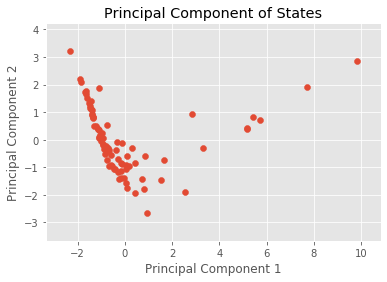

In [28]:
dat=Database[['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed']].dropna()
sca=scale(dat)
pca_model = PCA()
X_PCA = pca_model.fit_transform(sca)
fig, ax = plt.subplots()
ax.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)
plt.scatter(X_PCA[:,0],X_PCA[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component of States')

next we see if which prnicpal components to use

In [29]:
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

[0.57204901 0.17122451 0.1048144  0.06130814 0.04546535 0.02423484
 0.01563137 0.00527239]


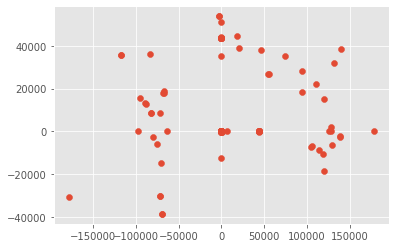

In [30]:
#Scatter from excel sheets
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8"])
plt.scatter(Database['Long'],Database['Lat'])

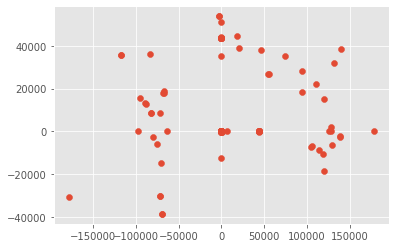

In [31]:
#Scatter from excel sheets
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8"])
plt.scatter(Database['Long'],Database['Lat'])

C:\Users\Kathryn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


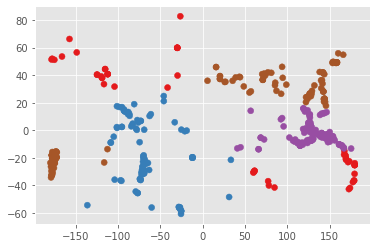

In [32]:
#Kmeans from USGS data. We will use k-means for all other data
quac=Current[['latitude','longitude']]
scal=scale(quac)
y_pred = KMeans(n_clusters=7,n_init=50).fit_predict(scal)
quac['grouping']=y_pred
Current['grouping']=y_pred
Help=Current[['grouping','Country']]
T=Help.groupby('Country').mean().reset_index()
Info=Information.merge(T,how='left',left_on='Country', right_on='Country')
Info.groupby('grouping').count()
plt.scatter(quac['longitude'],quac['latitude'],c=y_pred,cmap=cmap)

In [43]:
T

,Country,grouping
0,Afghanistan,4.00
1,Alaska,0.00
2,Algeria,4.00
3,Argentina,6.00
4,Banda Sea,2.00
...,...,...
77,Vanuatu,1.25
78,Venezuela,5.00
79,Wallis and Futuna,3.00
80,West Chile Rise,6.00


In [42]:
for i in range(len(T)):
    print(T.iloc[i, 0])

 Afghanistan
 Alaska
 Algeria
 Argentina
 Banda Sea
 British Indian Ocean Territory
 CA
 Cayman Islands
 Central East Pacific Rise
 Central Mid-Atlantic Ridge
 Chagos Archipelago region
 Chile
 China
 Colombia
 Comoros
 Costa Rica
 Croatia
 Drake Passage
 East Timor
 Ecuador
 Ecuador region
 Fiji
 Fiji region
 France
 Galapagos Triple Junction region
 Greece
 Greenland
 Guam
 Guatemala
 Honduras
 Idaho
 India
 Indonesia
 Iran
 Japan
 Kermadec Islands region
 Kyrgyzstan
 Mexico
 Micronesia
 Mid-Indian Ridge
 Mongolia
 Mozambique
 Nevada
 New Caledonia
 New Zealand
 Nicaragua
 Northern Mariana Islands
 Northern Mid-Atlantic Ridge
 Off the coast of Central America
 Owen Fracture Zone region
 Pacific-Antarctic Ridge
 Papua New Guinea
 Peru
 Philippines
 Portugal
 Reykjanes Ridge
 Russia
 Solomon Islands
 South Georgia and the South Sandwich Islands
 South Sandwich Islands
 South of Africa
 South of Panama
 South of the Fiji Islands
 South of the Kermadec Islands
 Southeast Indian Ridge
 So

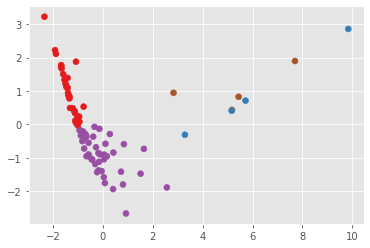

In [33]:
#K-Means is the best
y_pred = KMeans(n_clusters=4).fit_predict(sca)
dat['grouping']=y_pred
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred,cmap=cmap)

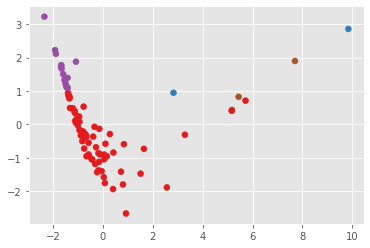

In [34]:
agg_cluster_model = AgglomerativeClustering(linkage='complete', affinity='euclidean', n_clusters=7)
y_pred1 = agg_cluster_model.fit_predict(sca)
dat['grouping1']=y_pred1
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred1,cmap=cmap)

### Stage 3: Regressions on Clustered Data

## Results and Validation [Check Off: Katie, Paul]

In [35]:
# Information about the Magna, UT earthquake on Wednesday, March 18th, 2020. Taken from the Earthquake Impact Database 
#on April 12th, 2020
utah_magnitude = 5.7
utah_intensity = 7
utah_fatalities = 0
utah_injuries = 0
utah_displaced = 150
utah_impact = 0.742
utah_buildings_damaged = 192
utah_buildings_destroyed = 0

In [36]:
#Probability analysis of earthquakes to be expanded for USGS map
def probability(c):
    its=[2,3,4,5,6,7,8,9,10]
    m=[]
    for i in range(len(its)-1):
        stamp=earthquake_data[(its[i]<= earthquake_data['Magnitude'])&(earthquake_data['Magnitude']<its[i+1])]
        try:
            t=len(stamp.groupby(['Country']).get_group(c))/len(earthquake_data.groupby(['Country']).get_group(c))*100
        except:
            t='nana'
        m.append(t)
    return(m)

probability('United Kingdom')

[50.0, 25.0, 25.0, 'nana', 'nana', 'nana', 'nana', 'nana']

## Conclusions [Check Off: Katie, Paul]